In [1]:
#create edges
import json
threshold = 20
nodes_count = 30
weigh = [[0 for i in range(nodes_count)] for j in range(nodes_count)]
def get_sim(user_list):
    for i in range(nodes_count):
        for j in range(nodes_count):
            weigh[i][j]=abs(user_list[i]['league']['vs']-user_list[j]['league']['vs'])
if __name__ == '__main__':
    path = "./alluser_tetr"
    dict_raw = json.load(open(path,'r',encoding='utf-8'))
    user_list = dict_raw['data']['users']
    #32024 nodes
    get_sim(user_list)
    #output graph
    with open("./test.txt","wt",encoding='utf-8') as f:
        for i in range(nodes_count):
            for j in range(nodes_count):
                if weigh[i][j]<threshold :
                    print(i,j,file=f)

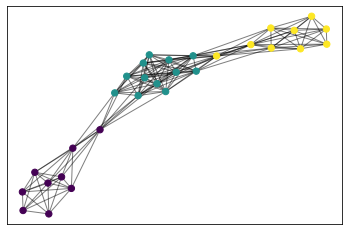

{'0': 1, '1': 0, '2': 1, '7': 0, '9': 1, '12': 1, '15': 1, '16': 1, '17': 1, '18': 1, '19': 1, '22': 1, '24': 1, '28': 1, '4': 0, '6': 0, '8': 0, '13': 0, '11': 2, '27': 2, '3': 0, '5': 0, '10': 0, '14': 2, '20': 2, '21': 2, '23': 2, '25': 2, '26': 2, '29': 2}


In [2]:
#1.louvain method
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import collections
import random
G = nx.read_edgelist("./test.txt")
partition = community_louvain.best_partition(G)
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
print(partition)

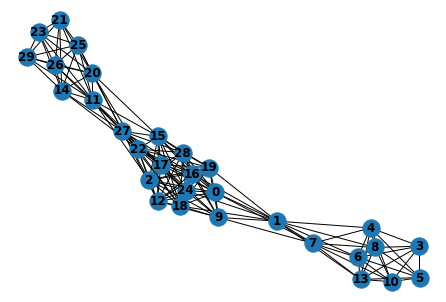

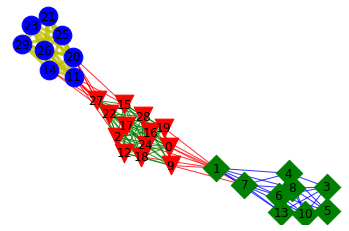

[['0', '16', '2', '19', '24', '22', '17', '15', '12', '18', '28', '27', '9'], ['10', '8', '1', '5', '4', '6', '3', '13', '7'], ['23', '29', '25', '21', '20', '11', '26', '14']]


In [5]:
#2.Girvan-Newman method
import json
import networkx as nx
import matplotlib.pyplot as plt
threshold = 20
nodes_count = 30
weigh = [[0 for i in range(nodes_count)] for j in range(nodes_count)]
def get_sim(user_list):
    for i in range(nodes_count):
        for j in range(nodes_count):
            weigh[i][j]=abs(user_list[i]['league']['vs']-user_list[j]['league']['vs'])
def clone_graph(G):
    cloned_graph = nx.Graph()
    for edge in G.edges():
        cloned_graph.add_edge(edge[0], edge[1])
    return cloned_graph
def cal_Q(partition, G):
    m = len(list(G.edges()))  #边的个数
    a = []
    e = []
    # 计算每个社区的a值
    for community in partition:
        t = 0
        for node in community:
            t += len(list(G.neighbors(node)))
        a.append(t / float(2 * m))
    # 计算每个社区的e值
    for community in partition:
        t = 0
        for i in range(len(community)):
            for j in range(len(community)):
                if i != j:
                    if G.has_edge(community[i], community[j]):
                        t += 1
        e.append(t / float(2 * m))
    # 计算Q
    q = 0
    for ei, ai in zip(e, a):
        q += (ei - ai ** 2)
    return q
class GN(object):
    def __init__(self, G):
        self._G_cloned = clone_graph(G)
        self._G = G
        self._partition = [[n for n in G.nodes()]]
        self._max_Q = 0.0
 
    # GN算法
    def execute(self):
        while len(self._G.edges()) > 0:
            # 1.计算所有边的edge betweenness
            edge = max(nx.edge_betweenness(self._G).items(),
                       key=lambda item: item[1])[0]
            # 2.移去edge betweenness最大的边
            self._G.remove_edge(edge[0], edge[1])
            # 获得移去边后的子连通图
            components = [list(c) for c in list(nx.connected_components(self._G))]
            if len(components) != len(self._partition):
                # 3.计算Q值
                cur_Q = cal_Q(components, self._G_cloned)
                # print(cur_Q)
                if cur_Q > self._max_Q:
                    self._max_Q = cur_Q
                    self._partition = components
        return self._partition
 
 
# 可视化划分结果
def showCommunity(G, partition, pos):
    # 划分在同一个社区的用一个符号表示，不同社区之间的边用黑色粗体
    cluster = {}
    labels = {}
    for index, item in enumerate(partition):
        for nodeID in item:
            labels[nodeID] = r'$' + str(nodeID) + '$'  # 设置可视化label
            cluster[nodeID] = index  # 节点分区号
 
    # 可视化节点
    colors = ['r', 'g', 'b', 'y', 'm']
    shapes = ['v', 'D', 'o', '^', '<']
    for index, item in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=item,
                               node_color=colors[index],
                               node_shape=shapes[index],
                               node_size=350,
                               alpha=1)
 
    # 可视化边
    edges = {len(partition): []}
    for link in G.edges():
        # cluster间的link
        if cluster[link[0]] != cluster[link[1]]:
            edges[len(partition)].append(link)
        else:
            # cluster内的link
            if cluster[link[0]] not in edges:
                edges[cluster[link[0]]] = [link]
            else:
                edges[cluster[link[0]]].append(link)
 
    for index, edgelist in enumerate(edges.values()):
        # cluster内
        if index < len(partition):
            nx.draw_networkx_edges(G, pos,
                                   edgelist=edgelist,
                                   width=1, alpha=0.8, edge_color=colors[index])
        else:
            # cluster间
            nx.draw_networkx_edges(G, pos,
                                   edgelist=edgelist,
                                   width=3, alpha=0.8, edge_color=colors[index])
 
    # 可视化label
    nx.draw_networkx_labels(G, pos, labels, font_size=12)
 
    plt.axis('off')
    plt.show()
 
 
if __name__ == '__main__':
    # 加载网络数据并可视化
    G = nx.read_edgelist("./test.txt")
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold')
    plt.show()
 
    # GN算法
    algo = GN(G)
    partition = algo.execute()
 
    # 可视化结果
    showCommunity(algo._G_cloned, partition, pos)
    print(partition)

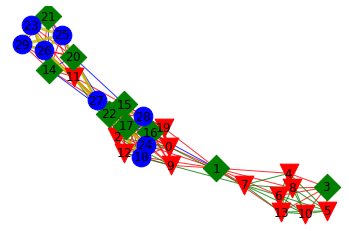

[['0', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '19'], ['1', '3', '14', '15', '16', '17', '20', '21', '22'], ['18', '23', '24', '25', '26', '27', '28', '29']]


In [6]:
#3.Markov Clustering method
import markov_clustering as mc
import networkx as nx
import random

# number of nodes to use
numnodes = 30

# generate random positions as a dictionary where the key is the node id and the value
# is a tuple containing 2D coordinates
positions = {i:(random.random() * 2 - 1, random.random() * 2 - 1) for i in range(numnodes)}

# use networkx to generate the graph
network = nx.random_geometric_graph(numnodes, 0.3, pos=positions)

# then get the adjacency matrix (in sparse form)
G = nx.read_edgelist("./test.txt")
matrix = nx.to_scipy_sparse_matrix(G)
result = mc.run_mcl(matrix)           # run MCL with default parameters
clusters = mc.get_clusters(result)    # get clusters
tran=[[]for i in range(3)]
for i in range (3):
    size=len(clusters[i])
    for j in range (size):
        tran[i].append(str(clusters[i][j]))
showCommunity(G, tran, pos)
print(tran)